<a href="https://colab.research.google.com/github/shajibghosh/counterfeit-ic-detection-tutorial/blob/main/counterfeit_ic_detection.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Counterfeit IC Detection using Deep Learning**
> The purpose of this notebook is to introduce the learners to -
*   Counterfeit integrated circuits, counterfeit types and defects
*   Training a convolutional neural network model from scratch for detecting counterfeit ICs using a custom optical image dataset 
*   Techniques for data splitting for training and validation
*   Evaluate the trained algorithm using the test images 
*   Transfer learning and fine-tuning
*   Hyperparameter tuning 



Throughout this notebook, `PyTorch` deep learning framework along with some standard data analysis and visualization libraries (e.g., `Numpy`, `PIL`, `Matplotlib`, `Pandas`, `OpenCV` or `cv2`, `scikit-learn`) will be used. It includes a computer vision package called `torchvision` which has a simple API for image pre-processing in its `torchvision.transforms` module. The module provides users with a simple approach to create new custom transforms while also providing a collection of standard, composable image transformations.
These customized transforms may be used in the image pre-processing pipeline just like any other transforms from the module. 

***Useful introduction to [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb)***

***How to run Google Colab Notebook:*** https://www.youtube.com/watch?v=yEIc9z-Ad3k 

***More on PyTorch: [Introduction to PyTorch](https://www.youtube.com/watch?v=IC0_FRiX-sw)***

***Useful documentations on [torchvision](https://pytorch.org/vision/stable/index.html) and [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)***

# **Instructions**

*   Read the description and execute each cell. To execute a cell either press `Ctrl + Enter` or click on the `Run cell` or `play` button at the left of each cell.
*   Some cells may contain paramters/variables. You'll be asked to change the value of those parameters/variables, get the results and report them.

* Try to answer the questions.

* Run the experiments with the custom dataset available [here](https://www.dropbox.com/sh/apz9q7zw7ehtob0/AAAQwZVmwMQsN9XQI1V0DrhMa?dl=0). 

>[Note: *For accessing the dataset folder and downloading them you'll require a password. For the permission and password, please email at `shajib [dot] ghosh [at] ufl [dot] edu`* ]

# **Counterfeit integrated circuits, counterfeit types and defects**

> Counterfeit integrated circuits (ICs) are a major source of concern for the government and the industry because they may compromise the security and dependability of a wide range of electronic systems. Such devices can be changed to contain malicious code or hidden "backdoors" that can disable systems, intercept communications, and intrude into computer networks. Therefore, understanding which ICs are most likely to be counterfeit and which sectors are most affected is becoming increasingly important.

>A novel comprehensive taxonomy of different counterfeit types is shown in the following figure:

>![fig1.png](https://www.researchgate.net/profile/Ujjwal-Guin/publication/268686677/figure/fig3/AS:667620252594178@1536184480267/Taxonomy-of-counterfeit-types.png)

> For detecting counterfeit ICs, a number of test techniques are now available.The objective of these approaches is to find "defects" in an IC that is being investigated. Anomalies and modifications not present in authentic ICs are referred to as counterfeit defects. A counterfeit IC is likely to have one or more abnormalities and departures from an authentic IC's normal/usual shape and/or functioning. Anomalies may vary based on size, shape, type, number, etc., depending on the capabilities possessed by the counterfeiters. An updated and expanded taxonomy of defects and anomalies present in counterfeit electronic components is presented in the following figure: 

>![fig2.png](https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs10836-013-5428-2/MediaObjects/10836_2013_5428_Fig3_HTML.gif?as=webp)

Reference: [Counterfeit Integrated Circuits: Detection and Avoidance](https://link.springer.com/book/10.1007/978-3-319-11824-6)

**More on acquiring optical images of the ICs for physical inspection-based counterfeit detection will be found [here](https://drive.google.com/file/d/1w0xct8VLbIhMQI4UkwOzMCbH4M5AI2mS/view?usp=sharing)**.

>[Note: *For accessing the lab tutorial document you'll require a password. For the permission and password, please email at `shajib [dot] ghosh [at] ufl [dot] edu`* ]

# Step - 1: Collecting the dataset and mounting Google Drive locally

> As mentioned earlier, you will be able to download the dataset from [this link](https://www.dropbox.com/sh/apz9q7zw7ehtob0/AAAQwZVmwMQsN9XQI1V0DrhMa?dl=0), once you have the permission. 

> After downloading the dataset, please follow the steps below:
*   Upload the dataset folder in your Google Drive `[Please DO NOT share the data without permission]`
*   Mount your Google Drive on your runtime

>For details, please check this: [Working with Data](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step - 2: Loading the dependencies
> This section loads some required libraries and modules used in this notebook: **numpy**, **pandas**, **matplotlib**, **PIL**, **torch**, **torchvision.transforms**
*   [Numpy](https://www.numpy.org/) is an array manipulation library, used for linear algebra, Fourier transform, and random number capabilities.
*   [Pandas](https://pandas.pydata.org/) is a library for data manipulation and data analysis.
*   [Matplotlib](https://matplotlib.org/) is a library which generates figures and provides graphical user interface toolkit.
*   [PIL](https://pillow.readthedocs.io/en/stable/) or *Python Imaging Library* provides extensive file format support, an efficient internal representation, and fairly powerful image processing capabilities.
*   [cv2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) is a library for computer vision tasks.
*   Scikit-learn, also known as [sklearn](https://scikit-learn.org/stable/) is an open-source, machine learning and data modeling library for Python.
*   [torch](https://) is an open-source package/library that serves as the foundation for the `PyTorch framework`. This package offers multi-dimensional tensor data structures as well as mathematical operations on these tensors.
It also includes several utilities for efficient serialization of Tensors and arbitrary types, as well as other helpful utilities. 
*   [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html#transforms) module provides many important transforms that can be used to perform different types of manipulations on the image data.


In [138]:
import sys
import os
import random
import shutil
import itertools

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.utils.data as Data
from torch.utils.data import Dataset, TensorDataset, random_split, SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision.models as models
from torch import optim, nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.autograd import Variable


from PIL import Image, ImageFile

# Step - 3: Setting up the working directory
> In this step, we will set up the current working directory to 'drive/MyDrive/dataset/', where all the `train` and `test` image data are located. 

In [4]:
# setting up the current working directory
os.chdir('drive/MyDrive/dataset/')

In [5]:
parent_dir = os.getcwd()
train_dir = os.path.join(parent_dir, 'train')
test_dir = os.path.join(parent_dir, 'test')
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv'), encoding='windows-1252')
test_df = pd.read_csv(os.path.join(test_dir,'test.csv'))

# Step - 4: Adding a fixed seed value
> A fixed seed value always yields the same set of random numbers. 

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2022
seed_everything(SEED)

# Step - 5: Displaying sample images from the dataset

In [7]:
# Dataset statistics
train_dir_SM = os.path.join(train_dir, 'STEMI_508')
train_dir_DSLR = os.path.join(train_dir, 'DSLR')
test_dir_imgs = os.path.join(test_dir, 'imgs')
print(f"Total number of Stereo Microscope images for training: {len(os.listdir(train_dir_SM))}")
print(f"Total number of DSLR images for training: {len(os.listdir(train_dir_DSLR))}")
print(f"Total number of images for testing: {len(os.listdir(test_dir_imgs))}")

Total number of Stereo Microscope images for training: 60
Total number of DSLR images for training: 40
Total number of images for testing: 10


In [8]:
# re-arranging the image data in new folder for smooth data handling 

new_train_dir = os.path.join(parent_dir,'training')
new_test_dir = os.path.join(parent_dir,'testing')
new_train_dir_temp = os.path.join(parent_dir, 'train_temp')

try:
    os.mkdir(new_train_dir)
    os.mkdir(new_test_dir)
    os.mkdir(new_train_dir_temp)
    os.mkdir(os.path.join(new_train_dir,'counterfeit'))
    os.mkdir(os.path.join(new_train_dir,'authentic'))
except OSError:
    pass

def move_files(source_dir, destination_dir):
    for fname in os.listdir(source_dir):
        if fname.split('-')[0] == 'A':
            srcpath = os.path.join(source_dir, fname) 
            destPath = os.path.join(os.path.join(destination_dir, 'authentic'), fname)
            shutil.copyfile(srcpath, destPath)
        elif fname.split('-')[0] == 'C':
            srcpath = os.path.join(source_dir, fname) 
            destPath = os.path.join(os.path.join(destination_dir, 'counterfeit'), fname)
            shutil.copyfile(srcpath, destPath)
    print("Files moved successfully.")

def move_files_temp(src_dir, dst_dir):
    for f in os.listdir(src_dir):
        src_path = os.path.join(src_dir, f)
        dest_Path = os.path.join(dst_dir, f)
        shutil.copyfile(src_path, dest_Path)
    print("Files moved successfully.")   

move_files(train_dir_SM, new_train_dir)
move_files(train_dir_DSLR, new_train_dir)
move_files_temp(test_dir_imgs, new_test_dir)
move_files_temp(train_dir_SM, new_train_dir_temp)
move_files_temp(train_dir_DSLR, new_train_dir_temp)

total_authentic_train = len(os.listdir(os.path.join(new_train_dir, 'authentic')))
total_counterfeit_train = len(os.listdir(os.path.join(new_train_dir, 'counterfeit')))

total_train_images = total_authentic_train + total_counterfeit_train
total_test_images = len(os.listdir(new_test_dir))

print(f"Total number of IC images for training: {total_train_images}")
print(f"Total number of IC images for testing: {total_test_images}")
print(f"Total number of authentic IC images for training: {total_authentic_train}")
print(f"Total number of counterfeit IC images for training: {total_counterfeit_train}")

Files moved successfully.
Files moved successfully.
Files moved successfully.
Files moved successfully.
Files moved successfully.
Total number of IC images for training: 100
Total number of IC images for testing: 10
Total number of authentic IC images for training: 60
Total number of counterfeit IC images for training: 40


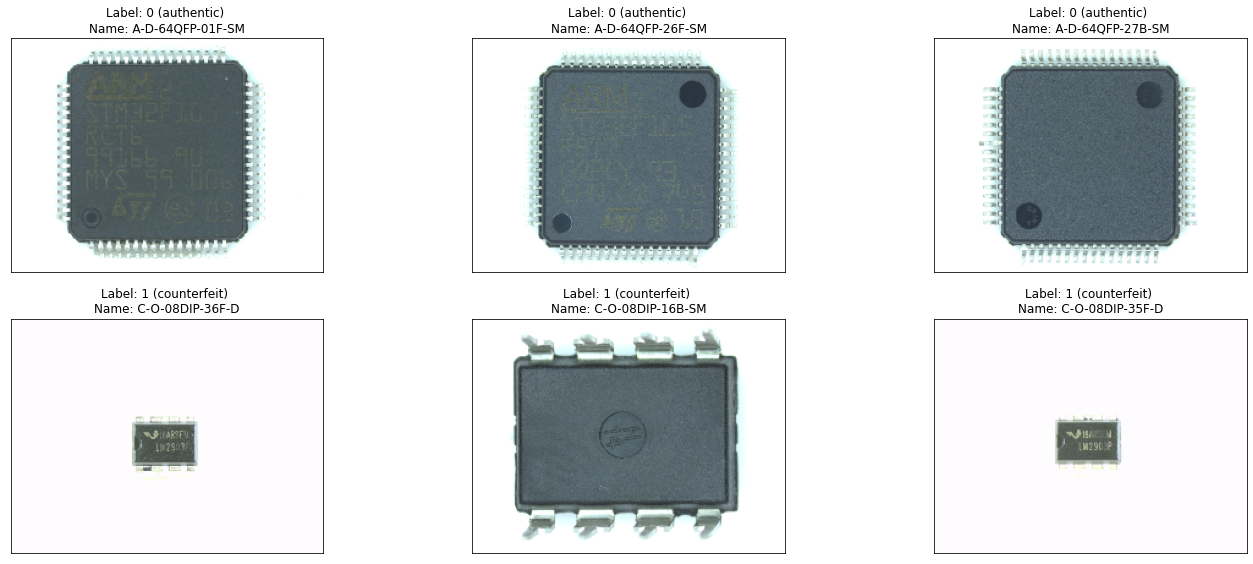

In [9]:
# Displaying sample images
%matplotlib inline

fig = plt.figure(figsize=(40, 25))
classes = ['authentic', 'counterfeit']
for class_id in sorted(train_df['label'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['label'] == class_id].sample(3, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        img_path= os.path.join(new_train_dir_temp, row['id'])
        image = cv2.imread(img_path + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 192))

        plt.imshow(image)
        ax.set_title('Label: %d (%s) \nName: %s' % (class_id, classes[class_id], row['id']) )

# Step - 6: Visualizing data distribution


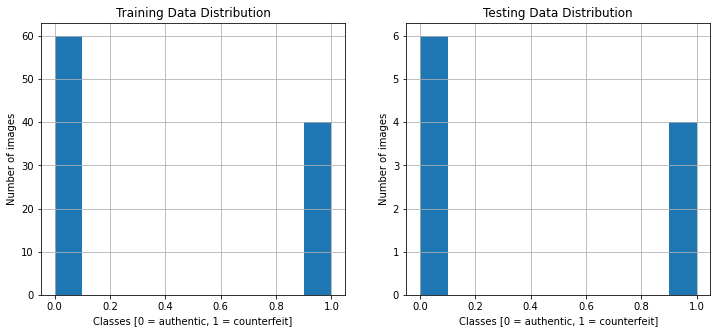

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
imgplot = train_df.label.hist()
ax.set_title('Training Data Distribution')
ax.set_xlabel('Classes [0 = authentic, 1 = counterfeit]')
ax.set_ylabel('Number of images')
ax = fig.add_subplot(1, 2, 2)
imgplot = test_df.actual_label.hist()
ax.set_title('Testing Data Distribution')
ax.set_xlabel('Classes [0 = authentic, 1 = counterfeit]')
ax.set_ylabel('Number of images')
plt.show()

# Step - 7: Creating a deep learning model from scratch

> A deep learing model can be compared to a black box. In our case, input and output data are feeded to it's two ends and it learns to map input to output during training.

> With all the resources we have by now, we can develop our pipeline for training a model. We will use **[Pytorch](https://pytorch.org/)** framework for the task. The procedures are described step by step below.

# **Convolutional Neural Networks**
> Convolutional Neural Network is a special variant of Deep Neural Network. In Convolutional Neural Networks, every image input is treated as a a matrix of pixel values which represents the amount of darkness at a given pixel in the image. Unlike, tradational neural networks which treats an image as a one dimentional network, CNNs considers the location of pixels and the neighbours for classification.

<br>

![](http://www.mdpi.com/information/information-07-00061/article_deploy/html/images/information-07-00061-g001.png)

<br>

# **Key components of a Convolutional Neural Network** 

>- **Convolutional layer:** In this layer, a kernel (or weight) matrix is used to extract low level features from the images. The kernel with its weights rotates over the image matrix in a sliding window fashion in order to obtained the convolved output. The kernel matrix behaves like a filter in an image extracting particular information from the original image matrix. During the colvolution process, The weights are learnt such that the loss function is minimized.

>- **Stride:** Stride is defined as the number of steps the kernel or the weight matrix takes while moving across the entire image moving N pixel at a time. If the weight matrix moves N pixel at a time, it is called stride of N.

>- **Pooling Layer:**  Pooling layers are used to extract the most informative features from the generated convolved output. 

>![](https://929687.smushcdn.com/2633864/wp-content/uploads/2021/05/max_pooling_demo.png?size=630x336&lossy=1&strip=1&webp=1)

>- **Output Layer:** To generate the final output, a dense or a fully connected layer is applied with the softmax activation function. Softmax function is used to generate the probabilities for each class of the target variable. 

**Image Credits:**
 
>1.  **www.deeplearning.net** 
>2.   **[Convolutional Neural Networks (CNNs) and Layer Types](https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/)**


**Courtesy: [A Very Comprehensive Tutorial : NN + CNN](https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn)**

# **Check the availability of GPU**
> GPUs are optimized to do matrix operations much faster than CPUs. Since training models involve large matrix operations, using GPU facility would make these operations much faster and more precise. However, not all computers come with GPUs. So, we will check whether there is GPU available and if so, then we will load our data and model into it.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")

# **Train-Validation Split**

>Instead of training over the whole dataset, we often split it into two parts named train and validation sets and train over the train set only. We then monitor the model's performance over the validation set. A good validation set resembles test dataset i.e., their class distribution are same and the metrics obtained over them should be close. 
If the dataset is quiet large, it is safe to assume that it's class distribution will be similar to that of test/unknown data. We use `Stratified Split` to create a validation dataset with same class elements ratio. 

In [23]:
k_value = 5 # You can change this value and report its impact on training and validation performances
splits=KFold(n_splits=k_value, shuffle=True, random_state=SEED)

# **Setting Parameters for training**

In [57]:
params = {'num_classes':2,                       # since there are two classes, i.e., authentic and counterfeit
          'criterion':nn.CrossEntropyLoss(),     # nn.BCEWithLogitsLoss()
          'img_size': 224,                       # you can change this value and observe the changes
          'num_epoch': 10,                       # you can change this value and observe the changes
          'batch_size':16,                       # you can change this value and observe the changes
          'num_worker':2,
          'LR': 1e-3,                            # you can change this value and observe the changes
          'models': 'resnet18'                   # 'resnet18', 'resnet34', 'resnet50', 'vgg16' 
          }

# **Loading the data for feeding into the CNN**

>There are several ways to load and feed data into a DNN. In Pytorch, we usually do it using `Dataset`. It is a class that samples chunks/batches of data from dataset. `Dataloader` is another class that uses `Dataset` to retrive data and/or corresponding outputs as batches. Later, these data batches are fed into model for training. In the following section, we will inherit pytorch's Dataset class and modify it in such a way that it will load images and corresponding DR severity levels and return them after applying some preprocessing. 

In [34]:
transform = transforms.Compose([
                transforms.ToTensor()
            ])
data_set = datasets.ImageFolder(root = new_train_dir, 
                                  transform = transform)

data_loader = Data.DataLoader(data_set, 
                                 shuffle = False, 
                                 batch_size = params['batch_size'],
                                 num_workers= params['num_worker'])

# **Data augmentations**
>Augmentations are used to increase diversity of data available for training models, without actually collecting new data. It helps the model to genearalize and prevents overfitting.

In [35]:
# finding mean and std values for normalizing the dataset
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = (images.mean([0,2,3])).tolist(), (images.std([0,2,3])).tolist()
  return mean, std

mean, std = mean_std(data_loader)
print("Obtained mean and std for normalization: ")
print("mean: \n", mean)
print("std: \n", std)

# data augmentation using obtained mean and std
transform_main = transforms.Compose([
    transforms.RandomRotation(180),  # you can change this value and observe the results
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize([params['img_size'], params['img_size']]),  
    transforms.Normalize(mean=mean,
                         std=std)
    ])

# data augmentation using ImageNet mean and std
transform_pretrained = transforms.Compose([
    transforms.RandomRotation(180),  # you can change this value and observe the results
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize([params['img_size'], params['img_size']]),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

Obtained mean and std for normalization: 
mean: 
 [0.688105583190918, 0.7209309339523315, 0.7258808612823486]
std: 
 [0.3244476318359375, 0.2996302545070648, 0.29301759600639343]


> Very basic data augmentations have been applied. You can explore more as shown in the **[Part-1 Notebook](https://github.com/shajibghosh/counterfeit-ic-detection-tutorial)**

# **Creating a basic model**

>In this section, we will create a basic convolutional neural network with ***2 convolutional***, ***1 maxpooling*** and ***3 fully connected layers***. A neural network requires forward propagation for prediction and error calculation and backward propagation for updating weights. For getting a clear notion of how `backpropagation` works, **[this blogpost](https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd#:~:targetText=Backpropagation%20and%20computing%20gradients,and%20the%20desired%20output%20vector.)**  might be helpful. However, in PyTorch, we only have to deal with the forward propagation part. PyTorch ceates a graph of the model from the `forward propagation` and does the backward propagation or `backpropagation` by itself. 

>For creating a model and training it, we need a `class` with `forward` propagation part as a fucntion. Also, we'll require a **[loss function](https://algorithmia.com/blog/introduction-to-loss-functions#:~:targetText=Introduction%20to%20Loss%20Functions,matrix%20multiplication%20into%20deep%20learning.)** that estimates the error/statistical distance between model's prediction and actual output, an **[optimizer](https://medium.com/analytics-vidhya/optimization-algorithms-for-deep-learning-1f1a2bd4c46b#:~:targetText=In%20the%20context%20of%20deep,y'%20and%20actual%20value%20y.)** to guide the model towards convergence.

In [36]:
class CDModel(nn.Module):
  def __init__(self):
    super(CDModel, self).__init__()
    # convolutional layer1
    self.conv1 = nn.Conv2d(3, 16, 5)
    # max pooling layer
    self.pool = nn.MaxPool2d(2, 2)
    # convolutional layer2
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.dropout = nn.Dropout(0.2)
    # fully connected layer1
    self.fc1 = nn.Linear(32*53*53, 256)
    # fully connected layer2
    self.fc2 = nn.Linear(256, 84)
    # fully connected layer3
    self.fc3 = nn.Linear(84, 2)
    # Applying softmax function
    self.softmax = nn.LogSoftmax(dim=1) 
  
  # feed forward network 
  def forward(self, x):
    # add sequence of convolutional and max pooling layers
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = x.view(-1, 32 * 53 * 53)
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.softmax(self.fc3(x))
    return x  
   
     
# create model instance
custom_model = CDModel()
print(custom_model)

CDModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


# **Creating model object, loss fucntion and optimizers**

In [69]:
# for custom CNN model
basic_model = CDModel().to(device)
criterion = params['criterion']
optimizer_basic_model = optim.Adam(basic_model.parameters(), lr=params['LR'])

# **Evaluation Metric**
>We are going to use **[accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)** for our model evaluation. 
>We'll also explore `precision`, `recall`, `f1-score`, `ROC AUC score` during testing. 
>Details of these evaluation metrics for binary classification (which is our case) and multi-class prediction/classification problem will be found **[here.](https://thedigitalskye.com/2021/04/19/6-useful-metrics-to-evaluate-binary-classification-models/)**

> Useful modules for implementing these score functions to measure classification performance: **[model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)**

In [172]:
# Accuracy calculation
def accuracy(y_true, y_pred):
    return(accuracy_score(y_true, y_pred))

# Confusion matrix, Precision, Recall, and F1-score calculation
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    precision = TP/ (TP + FP)
    recall = TP/ (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    labels = ["authentic", "counterfeit"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    return precision, recall, f1_score

# Receiver Operating Characteristic (ROC) curve
def roc_curve_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for counterfeit and authentic IC classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
# Area Under the ROC curve or ROC AUC score calculation
def score_roc_auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

# Step - 8: Training and Evaluating the Deep Learning Model


# **Funtions for Training and Evaluation**

In [39]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    count = 1
    for images, labels in dataloader:
        count = count+1
        if len(labels)!=params['batch_size']:
           continue
        # move tensors to GPU if CUDA is available
        images,labels = images.to(device),labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = loss_fn(output,labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

In [40]:
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    count = 1
    for images, labels in dataloader:
        count = count+1
        if len(labels)!=params['batch_size']:
           continue
        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [41]:
def plot_loss_curve(epochs, train_loss, val_loss):
    loss_train = train_loss
    loss_val =  val_loss
    Epochs = range(1, epochs+1)
    plt.plot(Epochs, loss_train, 'g', label='Training loss')
    plt.plot(Epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

def plot_accuracy_curve(epochs, train_accuracy, val_accuracy):
    accuracy_train = train_accuracy
    accuracy_val =  val_accuracy
    Epochs = range(1, epochs+1)
    plt.plot(Epochs, accuracy_train, 'g', label='Training accuracy')
    plt.plot(Epochs, accuracy_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [73]:
def train_eval(dataset, data_split, device, input_model, model_name, optimizer, criterion):
  foldperf={}
  print("Training and evaluation using {}".format(model_name))
  for fold, (train_idx,val_idx) in enumerate(data_split.split(np.arange(len(dataset)))):

      print('Fold {}'.format(fold + 1))
      train_sampler = SubsetRandomSampler(train_idx)
      val_sampler = SubsetRandomSampler(val_idx)
      train_loader = Data.DataLoader(dataset, batch_size=params['batch_size'], sampler=train_sampler)
      val_loader = Data.DataLoader(dataset, batch_size=params['batch_size'], sampler=val_sampler)
      
      device = device
      model = input_model
      model.to(device)
      optimizer = optimizer

      history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}

      
      for epoch in range(params['num_epoch']):
          train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
          val_loss, val_correct=valid_epoch(model,device,val_loader,criterion)

          train_loss = train_loss / len(train_loader.sampler)
          train_acc = train_correct / len(train_loader.sampler) * 100
          val_loss = val_loss / len(val_loader.sampler)
          val_acc = val_correct / len(val_loader.sampler) * 100

          print("Epoch:{}/{} | AVG Training Loss:{:.3f} | AVG Validation Loss:{:.3f} | AVG Training Acc {:.2f} % | AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                              params['num_epoch'],
                                                                                                              train_loss,
                                                                                                              val_loss,
                                                                                                              train_acc,
                                                                                                              val_acc))
          history['train_loss'].append(train_loss)
          history['val_loss'].append(val_loss)
          history['train_acc'].append(train_acc)
          history['val_acc'].append(val_acc)

      foldperf['fold{}'.format(fold+1)] = history  
      t_loss = foldperf['fold{}'.format(fold+1)]['train_loss']
      v_loss = foldperf['fold{}'.format(fold+1)]['val_loss']
      t_acc = foldperf['fold{}'.format(fold+1)]['train_acc']
      v_acc = foldperf['fold{}'.format(fold+1)]['val_acc']
      %matplotlib inline
      fig = plt.figure(figsize=(12, 5))
      ax = fig.add_subplot(1, 2, 1)
      imgplot = plot_loss_curve(params['num_epoch'], t_loss, v_loss)
      ax.set_title('Loss curve for fold = {}'.format(fold+1))
      ax = fig.add_subplot(1, 2, 2)
      imgplot = plot_accuracy_curve(params['num_epoch'], t_acc, v_acc)
      ax.set_title('Accuracy curve for fold = {}'.format(fold+1))
      plt.show()
  if model_name == 'basic_model':
      torch.save(model,'k_cross_CNN.pt') 
  elif model_name == 'pretrained_model': 
      torch.save(model,'k_cross_CNN_pretrained.pt') 
  return foldperf

In [52]:
def perfold_eval(fold_dict):

  train_loss_f,val_loss_f,train_acc_f,val_acc_f=[],[],[],[]
  for f in range(1,k_value+1):

      train_loss_f.append(np.mean(fold_dict['fold{}'.format(f)]['train_loss']))
      val_loss_f.append(np.mean(fold_dict['fold{}'.format(f)]['val_loss']))

      train_acc_f.append(np.mean(fold_dict['fold{}'.format(f)]['train_acc']))
      val_acc_f.append(np.mean(fold_dict['fold{}'.format(f)]['val_acc']))

  print('Performance of {} fold cross validation:'.format(k_value))
  print("Average Training Loss: {:.3f} \nAverage Validation Loss: {:.3f} \nAverage Training Acc: {:.2f}% \nAverage Validation Acc: {:.2f}%".format(np.mean(train_loss_f),
                                                                                                                                                    np.mean(val_loss_f),
                                                                                                                                                    np.mean(train_acc_f),
                                                                                                                                                    np.mean(val_acc_f))) 

# **Training and Evaluation using the Custom CNN Model**

Training and evaluation using basic_model
Fold 1
Epoch:1/10 | AVG Training Loss:0.661 | AVG Validation Loss:0.611 | AVG Training Acc 60.00 % | AVG Validation Acc 35.00 %
Epoch:2/10 | AVG Training Loss:0.629 | AVG Validation Loss:0.581 | AVG Training Acc 62.50 % | AVG Validation Acc 25.00 %
Epoch:3/10 | AVG Training Loss:0.650 | AVG Validation Loss:0.574 | AVG Training Acc 61.25 % | AVG Validation Acc 35.00 %
Epoch:4/10 | AVG Training Loss:0.660 | AVG Validation Loss:0.595 | AVG Training Acc 61.25 % | AVG Validation Acc 45.00 %
Epoch:5/10 | AVG Training Loss:0.627 | AVG Validation Loss:0.553 | AVG Training Acc 65.00 % | AVG Validation Acc 50.00 %
Epoch:6/10 | AVG Training Loss:0.622 | AVG Validation Loss:0.554 | AVG Training Acc 68.75 % | AVG Validation Acc 45.00 %
Epoch:7/10 | AVG Training Loss:0.621 | AVG Validation Loss:0.659 | AVG Training Acc 63.75 % | AVG Validation Acc 40.00 %
Epoch:8/10 | AVG Training Loss:0.650 | AVG Validation Loss:0.574 | AVG Training Acc 56.25 % | AVG Valida

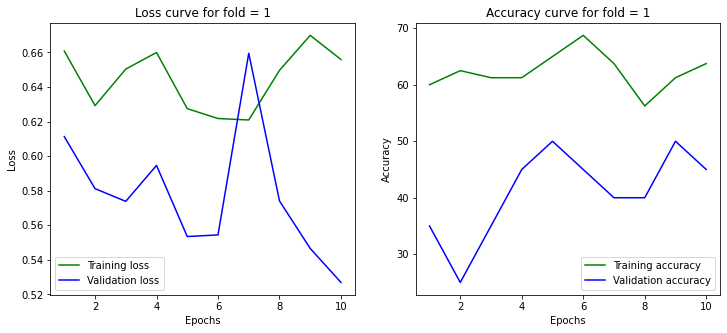

Fold 2
Epoch:1/10 | AVG Training Loss:0.678 | AVG Validation Loss:0.556 | AVG Training Acc 63.75 % | AVG Validation Acc 45.00 %
Epoch:2/10 | AVG Training Loss:0.655 | AVG Validation Loss:0.504 | AVG Training Acc 63.75 % | AVG Validation Acc 50.00 %
Epoch:3/10 | AVG Training Loss:0.648 | AVG Validation Loss:0.539 | AVG Training Acc 61.25 % | AVG Validation Acc 45.00 %
Epoch:4/10 | AVG Training Loss:0.602 | AVG Validation Loss:0.611 | AVG Training Acc 68.75 % | AVG Validation Acc 40.00 %
Epoch:5/10 | AVG Training Loss:0.623 | AVG Validation Loss:0.584 | AVG Training Acc 66.25 % | AVG Validation Acc 40.00 %
Epoch:6/10 | AVG Training Loss:0.590 | AVG Validation Loss:0.635 | AVG Training Acc 68.75 % | AVG Validation Acc 40.00 %
Epoch:7/10 | AVG Training Loss:0.669 | AVG Validation Loss:0.624 | AVG Training Acc 62.50 % | AVG Validation Acc 40.00 %
Epoch:8/10 | AVG Training Loss:0.672 | AVG Validation Loss:0.578 | AVG Training Acc 52.50 % | AVG Validation Acc 30.00 %
Epoch:9/10 | AVG Training

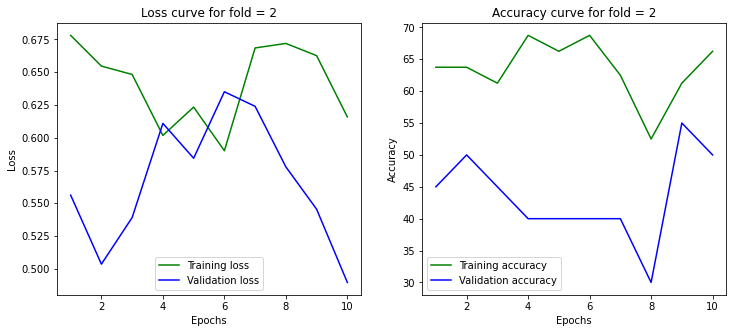

Fold 3
Epoch:1/10 | AVG Training Loss:0.627 | AVG Validation Loss:0.480 | AVG Training Acc 65.00 % | AVG Validation Acc 50.00 %
Epoch:2/10 | AVG Training Loss:0.691 | AVG Validation Loss:0.475 | AVG Training Acc 50.00 % | AVG Validation Acc 60.00 %
Epoch:3/10 | AVG Training Loss:0.633 | AVG Validation Loss:0.467 | AVG Training Acc 68.75 % | AVG Validation Acc 60.00 %
Epoch:4/10 | AVG Training Loss:0.654 | AVG Validation Loss:0.498 | AVG Training Acc 63.75 % | AVG Validation Acc 55.00 %
Epoch:5/10 | AVG Training Loss:0.659 | AVG Validation Loss:0.505 | AVG Training Acc 66.25 % | AVG Validation Acc 45.00 %
Epoch:6/10 | AVG Training Loss:0.625 | AVG Validation Loss:0.405 | AVG Training Acc 63.75 % | AVG Validation Acc 70.00 %
Epoch:7/10 | AVG Training Loss:0.623 | AVG Validation Loss:0.421 | AVG Training Acc 71.25 % | AVG Validation Acc 60.00 %
Epoch:8/10 | AVG Training Loss:0.645 | AVG Validation Loss:0.433 | AVG Training Acc 66.25 % | AVG Validation Acc 55.00 %
Epoch:9/10 | AVG Training

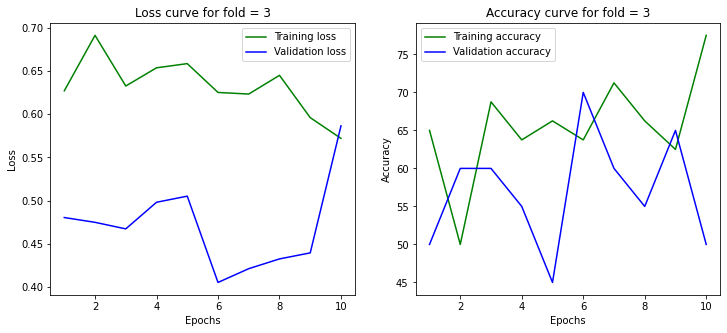

Fold 4
Epoch:1/10 | AVG Training Loss:0.598 | AVG Validation Loss:0.447 | AVG Training Acc 66.25 % | AVG Validation Acc 65.00 %
Epoch:2/10 | AVG Training Loss:0.588 | AVG Validation Loss:0.414 | AVG Training Acc 62.50 % | AVG Validation Acc 65.00 %
Epoch:3/10 | AVG Training Loss:0.612 | AVG Validation Loss:0.448 | AVG Training Acc 62.50 % | AVG Validation Acc 60.00 %
Epoch:4/10 | AVG Training Loss:0.601 | AVG Validation Loss:0.396 | AVG Training Acc 71.25 % | AVG Validation Acc 65.00 %
Epoch:5/10 | AVG Training Loss:0.597 | AVG Validation Loss:0.448 | AVG Training Acc 75.00 % | AVG Validation Acc 60.00 %
Epoch:6/10 | AVG Training Loss:0.590 | AVG Validation Loss:0.477 | AVG Training Acc 75.00 % | AVG Validation Acc 60.00 %
Epoch:7/10 | AVG Training Loss:0.599 | AVG Validation Loss:0.489 | AVG Training Acc 75.00 % | AVG Validation Acc 55.00 %
Epoch:8/10 | AVG Training Loss:0.560 | AVG Validation Loss:0.359 | AVG Training Acc 78.75 % | AVG Validation Acc 65.00 %
Epoch:9/10 | AVG Training

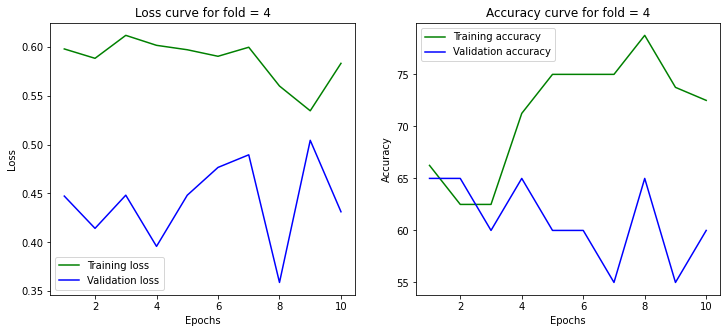

Fold 5
Epoch:1/10 | AVG Training Loss:0.568 | AVG Validation Loss:0.390 | AVG Training Acc 68.75 % | AVG Validation Acc 60.00 %
Epoch:2/10 | AVG Training Loss:0.571 | AVG Validation Loss:0.340 | AVG Training Acc 73.75 % | AVG Validation Acc 75.00 %
Epoch:3/10 | AVG Training Loss:0.524 | AVG Validation Loss:0.357 | AVG Training Acc 75.00 % | AVG Validation Acc 65.00 %
Epoch:4/10 | AVG Training Loss:0.478 | AVG Validation Loss:0.416 | AVG Training Acc 77.50 % | AVG Validation Acc 55.00 %
Epoch:5/10 | AVG Training Loss:0.520 | AVG Validation Loss:0.471 | AVG Training Acc 77.50 % | AVG Validation Acc 50.00 %
Epoch:6/10 | AVG Training Loss:0.536 | AVG Validation Loss:0.326 | AVG Training Acc 72.50 % | AVG Validation Acc 65.00 %
Epoch:7/10 | AVG Training Loss:0.568 | AVG Validation Loss:0.379 | AVG Training Acc 73.75 % | AVG Validation Acc 70.00 %
Epoch:8/10 | AVG Training Loss:0.549 | AVG Validation Loss:0.368 | AVG Training Acc 70.00 % | AVG Validation Acc 70.00 %
Epoch:9/10 | AVG Training

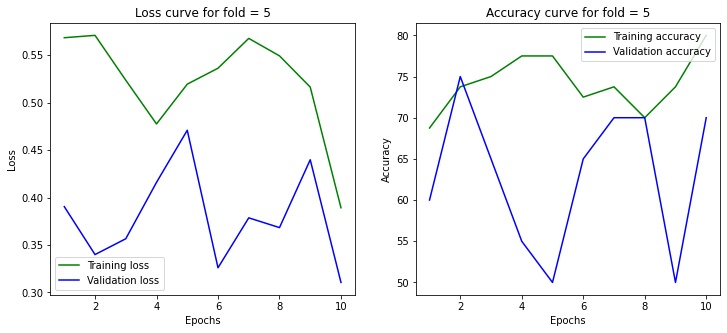

In [74]:
# dataloader for custom CNN model
dataset_main = datasets.ImageFolder(root = new_train_dir, 
                                  transform = transform_main)

# training and evaluation using the custom model
dict_kfold = train_eval(dataset_main, splits, device, basic_model, 'basic_model', optimizer_basic_model, criterion)

In [54]:
# performance summary of the custom CNN model 
perfold_eval(dict_kfold)

Performance of 5 fold cross validation:
Average Training Loss: 0.453 
Average Validation Loss: 0.374 
Average Training Acc: 79.08% 
Average Validation Acc: 61.40%


# Step - 9: Training and Evaluation using Transfer Learning


# **Transfer Learning**
>Training a Convolutional Neural Network from scratch presents several problems, most notably the volume of data required to train the network and the time required for training. Transfer learning is a method that lets us use a model trained for one task as a starting point for a machine learning model for a different task.

>Suppose a model is trained on the ImageNet dataset for image classification.
In such situation, we may "re-train" this model to recognize classes it was never trained to recognize in the first place!

>Imagine, you know how to ride a bicycle and want to learn how to ride a motorbike. Your bicycle riding skills — maintaining balance, maintaining direction, turning, and braking — can help you learn to ride a motorbike more quickly. In the case of a CNN, this is what transfer learning accomplishes.
Transfer learning allows you to employ a well-trained model directly by freezing the parameters, altering the output layer, and fine-tuning the weights.

>In essence, you may reduce the entire training method in half and get a high accuracy model in a fraction of the time. 

Reference: [PyTorch: Transfer Learning and Image Classification](https://pyimagesearch.com/2021/10/11/pytorch-transfer-learning-and-image-classification/)

In [62]:
# for pretrained model
pretrained_model_instance = getattr(models, params['models'])(pretrained=True)
IN_FEATURES = pretrained_model_instance.fc.in_features 
OUTPUT_DIM = params['num_classes']
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model_instance.fc = fc
pretrained_model = pretrained_model_instance.to(device)
criterion = params['criterion']
optimizer_pretrained = optim.Adam(pretrained_model.parameters(), lr=params['LR'])
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Fold 1
Epoch:1/10 | AVG Training Loss:1.161 | AVG Validation Loss:3.120 | AVG Training Acc 51.25 % | AVG Validation Acc 40.00 %
Epoch:2/10 | AVG Training Loss:1.018 | AVG Validation Loss:6.848 | AVG Training Acc 62.50 % | AVG Validation Acc 40.00 %
Epoch:3/10 | AVG Training Loss:0.303 | AVG Validation Loss:3.868 | AVG Training Acc 90.00 % | AVG Validation Acc 55.00 %
Epoch:4/10 | AVG Training Loss:0.331 | AVG Validation Loss:18.141 | AVG Training Acc 85.00 % | AVG Validation Acc 50.00 %
Epoch:5/10 | AVG Training Loss:0.306 | AVG Validation Loss:9.514 | AVG Training Acc 87.50 % | AVG Validation Acc 45.00 %
Epoch:6/10 | AVG Training Loss:0.264 | AVG Validation Loss:2.506 | AVG Training Acc 88.75 % | AVG Validation Acc 40.00 %
Epoch:7/10 | AVG Training Loss:0.220 | AVG Validation Loss:1.547 | AVG Training Acc 92.50 % | AVG Validation Acc 55.00 %
Epoch:8/10 | AVG Training Loss:0.149 | AVG Validation Loss:0.573 | AVG Training Acc 93.75 % | AVG Validation Acc 65.00 %
Epoch:9/10 | AVG Trainin

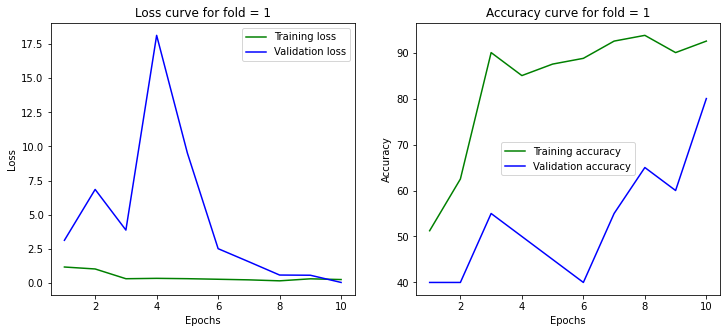

Fold 2
Epoch:1/10 | AVG Training Loss:0.126 | AVG Validation Loss:1.223 | AVG Training Acc 93.75 % | AVG Validation Acc 65.00 %
Epoch:2/10 | AVG Training Loss:0.068 | AVG Validation Loss:1.005 | AVG Training Acc 98.75 % | AVG Validation Acc 75.00 %
Epoch:3/10 | AVG Training Loss:0.204 | AVG Validation Loss:0.004 | AVG Training Acc 91.25 % | AVG Validation Acc 80.00 %
Epoch:4/10 | AVG Training Loss:0.099 | AVG Validation Loss:0.352 | AVG Training Acc 96.25 % | AVG Validation Acc 75.00 %
Epoch:5/10 | AVG Training Loss:0.183 | AVG Validation Loss:0.468 | AVG Training Acc 95.00 % | AVG Validation Acc 70.00 %
Epoch:6/10 | AVG Training Loss:0.112 | AVG Validation Loss:0.210 | AVG Training Acc 95.00 % | AVG Validation Acc 65.00 %
Epoch:7/10 | AVG Training Loss:0.078 | AVG Validation Loss:0.426 | AVG Training Acc 97.50 % | AVG Validation Acc 65.00 %
Epoch:8/10 | AVG Training Loss:0.155 | AVG Validation Loss:0.191 | AVG Training Acc 96.25 % | AVG Validation Acc 70.00 %
Epoch:9/10 | AVG Training

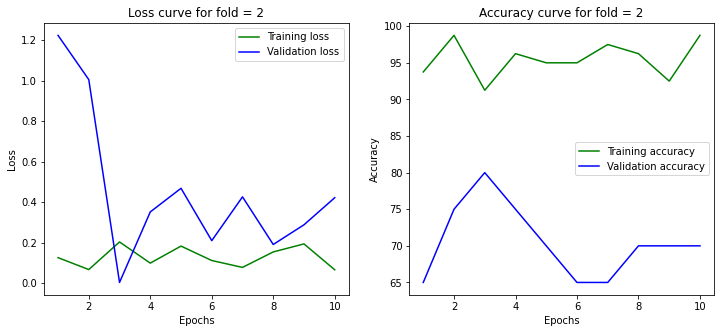

Fold 3
Epoch:1/10 | AVG Training Loss:0.184 | AVG Validation Loss:0.553 | AVG Training Acc 96.25 % | AVG Validation Acc 60.00 %
Epoch:2/10 | AVG Training Loss:0.052 | AVG Validation Loss:0.164 | AVG Training Acc 97.50 % | AVG Validation Acc 70.00 %
Epoch:3/10 | AVG Training Loss:0.037 | AVG Validation Loss:0.194 | AVG Training Acc 100.00 % | AVG Validation Acc 70.00 %
Epoch:4/10 | AVG Training Loss:0.160 | AVG Validation Loss:0.250 | AVG Training Acc 93.75 % | AVG Validation Acc 70.00 %
Epoch:5/10 | AVG Training Loss:0.090 | AVG Validation Loss:1.487 | AVG Training Acc 96.25 % | AVG Validation Acc 60.00 %
Epoch:6/10 | AVG Training Loss:0.038 | AVG Validation Loss:0.931 | AVG Training Acc 100.00 % | AVG Validation Acc 55.00 %
Epoch:7/10 | AVG Training Loss:0.068 | AVG Validation Loss:0.134 | AVG Training Acc 97.50 % | AVG Validation Acc 75.00 %
Epoch:8/10 | AVG Training Loss:0.071 | AVG Validation Loss:0.232 | AVG Training Acc 96.25 % | AVG Validation Acc 75.00 %
Epoch:9/10 | AVG Traini

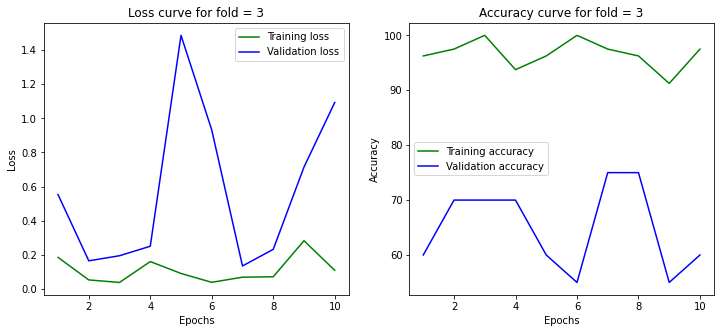

Fold 4
Epoch:1/10 | AVG Training Loss:0.236 | AVG Validation Loss:0.009 | AVG Training Acc 95.00 % | AVG Validation Acc 80.00 %
Epoch:2/10 | AVG Training Loss:0.140 | AVG Validation Loss:0.551 | AVG Training Acc 92.50 % | AVG Validation Acc 55.00 %
Epoch:3/10 | AVG Training Loss:0.050 | AVG Validation Loss:0.312 | AVG Training Acc 98.75 % | AVG Validation Acc 70.00 %
Epoch:4/10 | AVG Training Loss:0.127 | AVG Validation Loss:0.320 | AVG Training Acc 97.50 % | AVG Validation Acc 65.00 %
Epoch:5/10 | AVG Training Loss:0.090 | AVG Validation Loss:0.063 | AVG Training Acc 97.50 % | AVG Validation Acc 80.00 %
Epoch:6/10 | AVG Training Loss:0.065 | AVG Validation Loss:0.077 | AVG Training Acc 97.50 % | AVG Validation Acc 80.00 %
Epoch:7/10 | AVG Training Loss:0.093 | AVG Validation Loss:0.417 | AVG Training Acc 96.25 % | AVG Validation Acc 65.00 %
Epoch:8/10 | AVG Training Loss:0.102 | AVG Validation Loss:0.337 | AVG Training Acc 95.00 % | AVG Validation Acc 65.00 %
Epoch:9/10 | AVG Training

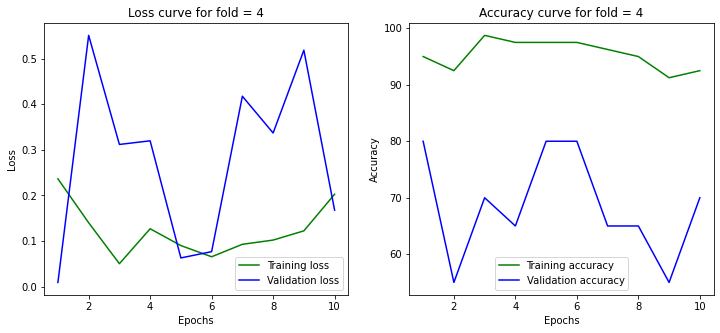

Fold 5
Epoch:1/10 | AVG Training Loss:0.223 | AVG Validation Loss:0.230 | AVG Training Acc 91.25 % | AVG Validation Acc 75.00 %
Epoch:2/10 | AVG Training Loss:0.092 | AVG Validation Loss:0.083 | AVG Training Acc 97.50 % | AVG Validation Acc 75.00 %
Epoch:3/10 | AVG Training Loss:0.132 | AVG Validation Loss:0.009 | AVG Training Acc 96.25 % | AVG Validation Acc 80.00 %
Epoch:4/10 | AVG Training Loss:0.084 | AVG Validation Loss:0.056 | AVG Training Acc 96.25 % | AVG Validation Acc 80.00 %
Epoch:5/10 | AVG Training Loss:0.060 | AVG Validation Loss:0.116 | AVG Training Acc 98.75 % | AVG Validation Acc 75.00 %
Epoch:6/10 | AVG Training Loss:0.048 | AVG Validation Loss:0.072 | AVG Training Acc 97.50 % | AVG Validation Acc 75.00 %
Epoch:7/10 | AVG Training Loss:0.392 | AVG Validation Loss:0.430 | AVG Training Acc 87.50 % | AVG Validation Acc 70.00 %
Epoch:8/10 | AVG Training Loss:0.071 | AVG Validation Loss:0.468 | AVG Training Acc 97.50 % | AVG Validation Acc 65.00 %
Epoch:9/10 | AVG Training

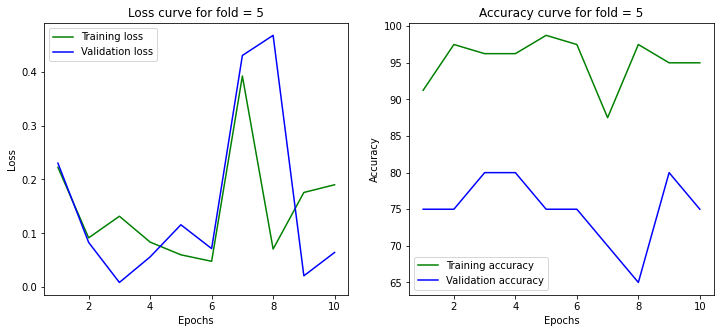

In [63]:
# dataloader for pre-trained model
dataset_pretrained = datasets.ImageFolder(root = new_train_dir, 
                                  transform = transform_pretrained)

# training and evaluation using the pretrained model
kfold_dict = train_eval(dataset_pretrained, splits, device, pretrained_model, 'pretrained_model', optimizer_pretrained, criterion)

In [64]:
# performance summary of the pretrained model 
perfold_eval(kfold_dict)

Performance of 5 fold cross validation:
Average Training Loss: 0.187 
Average Validation Loss: 1.227 
Average Training Acc: 93.22% 
Average Validation Acc: 66.40%


# Step - 10: Inference using the test data

# **Function definition**

In [119]:
def inference(transformer, model_file, img_path, device):
  checkpoint = torch.load(model_file)
  model = checkpoint
  #model.load_state_dict(checkpoint)
  model.eval()
  image = Image.open(img_path).convert('RGB')
  image_tensor = transformer(image)
  image_tensor = image_tensor.unsqueeze_(0) #so img is not treated as a batch 
  input_img = Variable(image_tensor)
  torch.no_grad()
  pred = F.softmax(model(input_img), dim=1)
  pred_probs = pred.detach().numpy()
  prob = torch.argmax(pred, 1)
  y_pred = prob.numpy()
  return y_pred

def prediction(data_directory, model_file, transform_f, device):
  preds_model = []
  model_f = model_file
  filesDir = os.listdir(data_directory)
  filesDir = sorted(filesDir,key=lambda x: int((x.split('.png')[0]).split('_')[1]))
  for i in range(1,len(filesDir)+1):
    img_file = filesDir[i-1]
    img_file_basename = img_file.split('.png')[0]
    if int(img_file_basename.split('_')[1]) == i:
      img_file_path = os.path.join(new_test_dir, img_file)
      print('Prediction for {}'.format(img_file))
      predictions = inference(transform_f, model_f, img_file_path, device)
      if int(predictions[0]) == 0:
        print('authentic (label: 0)')
      elif int(predictions[0]) == 1:
        print('counterfeit (label: 1)')
    preds_model.append(predictions)
    i+=1
  return preds_model 

In [117]:
#Test Data Transformation 
transformer_test = transforms.Compose([
                                  transforms.Resize([params['img_size'], params['img_size']]),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=mean,
                                                       std=std) 
                                  ])

In [120]:
# inference using the custom model
model_f_basic = '/content/drive/MyDrive/dataset/k_cross_CNN.pt'
preds_basic = prediction(new_test_dir, model_f_basic, transformer_test, device)

Prediction for sample_1.png
authentic (label: 0)
Prediction for sample_2.png
counterfeit (label: 1)
Prediction for sample_3.png
authentic (label: 0)
Prediction for sample_4.png
authentic (label: 0)
Prediction for sample_5.png
counterfeit (label: 1)
Prediction for sample_6.png
authentic (label: 0)
Prediction for sample_7.png
authentic (label: 0)
Prediction for sample_8.png
counterfeit (label: 1)
Prediction for sample_9.png
counterfeit (label: 1)
Prediction for sample_10.png
counterfeit (label: 1)


In [121]:
# inference using the pretrained model
model_f_pretrained = '/content/drive/MyDrive/dataset/k_cross_CNN_pretrained.pt'
preds_pretrained = prediction(new_test_dir, model_f_pretrained, transformer_test, device)

Prediction for sample_1.png
authentic (label: 0)
Prediction for sample_2.png
authentic (label: 0)
Prediction for sample_3.png
authentic (label: 0)
Prediction for sample_4.png
authentic (label: 0)
Prediction for sample_5.png
authentic (label: 0)
Prediction for sample_6.png
authentic (label: 0)
Prediction for sample_7.png
authentic (label: 0)
Prediction for sample_8.png
authentic (label: 0)
Prediction for sample_9.png
authentic (label: 0)
Prediction for sample_10.png
authentic (label: 0)


# **Model performance evaluation**

### **Performance of the basic CNN model**

In [165]:
# true label
y_true = test_df.actual_label

# predicted label
list_pred_basic = [arr.tolist() for arr in preds_basic]
y_pred_basic_df = pd.DataFrame(list(itertools.chain(*list_pred_basic)), columns = ['predicted_label'])
y_pred_basic =  y_pred_basic_df.predicted_label

Accuracy: 50.00%
ROC AUC Score: 0.5000
Precision: 40.00%
Recall: 50.00%
F1-score: 44.44%


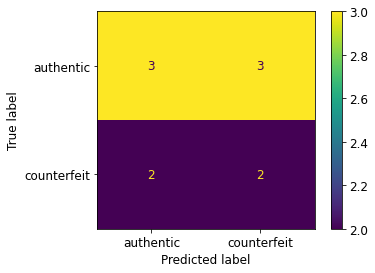

In [173]:
# accuracy
basic_accuracy = accuracy(y_true, y_pred_basic)*100
print("Accuracy: {:.2f}%".format(basic_accuracy))

# ROC AUC Score
roc_auc_basic = score_roc_auc(y_true, y_pred_basic)
print("ROC AUC Score: {:.4f}".format(roc_auc_basic))

# precision, recall, and f1-score
basic_precision, basic_recall, basic_f1_score = conf_matrix(y_true, y_pred_basic)
print("Precision: {:.2f}%".format(basic_precision*100))
print("Recall: {:.2f}%".format(basic_recall*100))
print("F1-score: {:.2f}%".format(basic_f1_score*100))

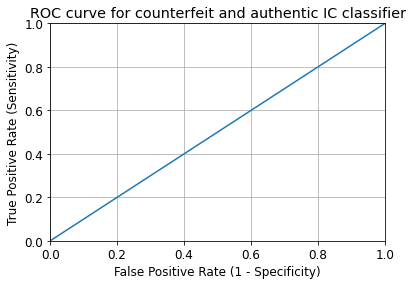

In [174]:
# ROC curve
roc_curve_plot(y_true, y_pred_basic)

### **Performance of the pretrained model**

In [175]:
# true label
y_true = test_df.actual_label

# predicted label
list_pred_pretrained = [arr.tolist() for arr in preds_pretrained]
y_pred_pretrained_df = pd.DataFrame(list(itertools.chain(*list_pred_pretrained)), columns = ['predicted_label'])
y_pred_pretrained =  y_pred_pretrained_df.predicted_label

Accuracy: 60.00%
ROC AUC Score: 0.5000
Precision: nan%
Recall: 0.00%
F1-score: nan%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


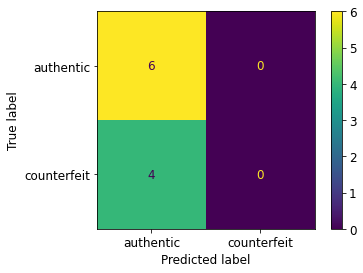

In [176]:
# accuracy
pretrained_accuracy = accuracy(y_true, y_pred_pretrained)*100
print("Accuracy: {:.2f}%".format(pretrained_accuracy))

# ROC AUC Score
roc_auc_pretrained = score_roc_auc(y_true, y_pred_pretrained)
print("ROC AUC Score: {:.4f}".format(roc_auc_pretrained))

# precision, recall, and f1-score
pretrained_precision, pretrained_recall, pretrained_f1_score = conf_matrix(y_true, y_pred_pretrained)
print("Precision: {:.2f}%".format(pretrained_precision*100))
print("Recall: {:.2f}%".format(pretrained_recall*100))
print("F1-score: {:.2f}%".format(pretrained_f1_score*100))

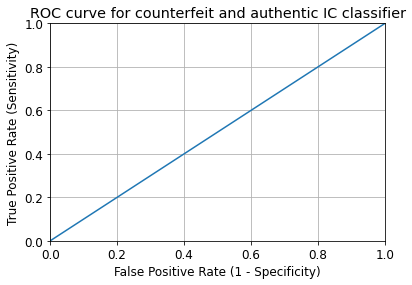

In [177]:
# ROC curve
roc_curve_plot(y_true, y_pred_pretrained)

# **Final Notes:**
*   Transfer learning obtained better results here. Can you explain the reason?
*   "Proper hyperparameter tuning and augmentation can boost the model performance." - Do you agree with the statement? Can you show the impact of hyperparameter tuning and different data augmentations based on this tutorial notebook? 
*   For deeper CNNs it will be difficult to run the training and evaluation in the notebook and often, `CUDA Memory Error` warning appears. Can you explain the reason? How can you avoid this error? 
* Carefully go through each cell's code blocks and the references. 